# Comprehensive EDA of Network Performance Data with PySpark

## Introduction

This notebook performs a detailed Exploratory Data Analysis (EDA) on a large mobile network performance dataset. Unlike a traditional Pandas-based approach, this entire analysis is conducted using **Apache Spark (via PySpark)**. This makes the process scalable to datasets that are far too large to fit into a single machine's memory.

**The Spark Philosophy for EDA:**
1.  **Distributed Computation:** All heavy data manipulation, aggregation, and calculation (e.g., `groupBy`, `agg`, `corr`) are performed across the Spark cluster.
2.  **Collect Small Results:** Visualization libraries like Matplotlib and Seaborn run on the driver node (the machine running the notebook) and require data in a local format (like a Pandas DataFrame). The strategy is to perform aggregations in Spark that result in a small summary table, and then use `.toPandas()` to bring that small result to the driver for plotting.
3.  **Avoid `.collect()` on large dataframes.**

**Objective:** To explore the dataset, clean and transform it, identify patterns, and derive actionable insights about network performance, all within a scalable Spark environment.

## 1. Setup: Initializing a Spark Session

First, we'll import the necessary libraries and create a `SparkSession`, which is the entry point to any Spark functionality.

In [13]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, isnull, from_unixtime, hour, date_format, avg
import pyspark.sql.functions as F
from pyspark.sql import types as T # CORRECTED: Import types for schema checking
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Set visualization styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("NetworkEDA") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session Created Successfully")

Spark Session Created Successfully


## 2. Data Loading and Initial Inspection

We'll load the data using `spark.read.csv`. We'll use `inferSchema=True` for EDA.

In [17]:
file_path = 'Train.csv' # Use 'Train.csv' for the full dataset

df = spark.read.csv(file_path, header=True, inferSchema=True)

print(f"Dataset Schema:")
df.printSchema()

print(f"\nNumber of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

print("\nFirst 5 rows:")
df.show(5, truncate=False)

Dataset Schema:
root
 |-- id: string (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- device: string (nullable = true)
 |-- PCell_RSRP_max: double (nullable = true)
 |-- PCell_RSRQ_max: double (nullable = true)
 |-- PCell_RSSI_max: double (nullable = true)
 |-- PCell_SNR_max: double (nullable = true)
 |-- PCell_Downlink_Num_RBs: double (nullable = true)
 |-- PCell_Downlink_Average_MCS: double (nullable = true)
 |-- PCell_Downlink_bandwidth_MHz: double (nullable = true)
 |-- PCell_Cell_Identity: double (nullable = true)
 |-- PCell_freq_MHz: double (nullable = true)
 |-- SCell_RSRP_max: double (nullable = true)
 |-- SCell_RSRQ_max: double (nullable = true)
 |-- SCell_RSSI_max: double (nullable = true)
 |-- SCell_SNR_max: double (nullable = true)
 |-- SCell_Downlink_Num_RBs: double (nullable = true)
 |-- SCell_Downlink_Average_MCS: double (nullable = true)
 |-- SCell_Downlink_bandwidth_MHz: double (nullable = true)
 |-- SCell_Cell_Identity: double (nullable = true)
 |-- SC

### 2.1. Handling Missing Values

In [18]:
# Efficiently count nulls for each column in Spark
null_counts = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
print("Null values in each column:")
null_counts.show()

Null values in each column:
+---+---------+------+--------------+--------------+--------------+-------------+----------------------+--------------------------+----------------------------+-------------------+--------------+--------------+--------------+--------------+-------------+----------------------+--------------------------+----------------------------+-------------------+--------------+--------+--------+---------+--------+---------+---+---------------+-----------------+-----------+-------------------+--------+--------+--------+---------+----------+-------+----------+------------------+----+------+
| id|timestamp|device|PCell_RSRP_max|PCell_RSRQ_max|PCell_RSSI_max|PCell_SNR_max|PCell_Downlink_Num_RBs|PCell_Downlink_Average_MCS|PCell_Downlink_bandwidth_MHz|PCell_Cell_Identity|PCell_freq_MHz|SCell_RSRP_max|SCell_RSRQ_max|SCell_RSSI_max|SCell_SNR_max|SCell_Downlink_Num_RBs|SCell_Downlink_Average_MCS|SCell_Downlink_bandwidth_MHz|SCell_Cell_Identity|SCell_freq_MHz|operator|Latitude|Lo

#### Cleaning Strategy (Spark Implementation)

In [19]:
# 1. Create 'has_scell' feature using withColumn
df_clean = df.withColumn('has_scell', col('SCell_RSRP_max').isNotNull())

# 2. Impute SCell numerical columns with 0
scell_cols = [c for c in df.columns if c.startswith('SCell_') and df.schema[c].dataType.simpleString() != 'string']
df_clean = df_clean.na.fill(0, subset=scell_cols)

# 3. Impute PCell columns with their mode
pcell_cols_to_fill = ['PCell_Downlink_bandwidth_MHz', 'PCell_Cell_Identity', 'PCell_freq_MHz']
for p_col in pcell_cols_to_fill:
    if df_clean.select(count(when(isnull(p_col), p_col))).collect()[0][0] > 0:
        mode_val = df_clean.groupBy(p_col).count().orderBy('count', ascending=False).first()[0]
        df_clean = df_clean.na.fill({p_col: mode_val})

print("Data cleaning complete. Verifying no nulls remain in imputed columns:")
df_clean.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

Data cleaning complete. Verifying no nulls remain in imputed columns:
+---+---------+------+--------------+--------------+--------------+-------------+----------------------+--------------------------+----------------------------+-------------------+--------------+--------------+--------------+--------------+-------------+----------------------+--------------------------+----------------------------+-------------------+--------------+--------+--------+---------+--------+---------+---+---------------+-----------------+-----------+-------------------+--------+--------+--------+---------+----------+-------+----------+------------------+----+------+
| id|timestamp|device|PCell_RSRP_max|PCell_RSRQ_max|PCell_RSSI_max|PCell_SNR_max|PCell_Downlink_Num_RBs|PCell_Downlink_Average_MCS|PCell_Downlink_bandwidth_MHz|PCell_Cell_Identity|PCell_freq_MHz|SCell_RSRP_max|SCell_RSRQ_max|SCell_RSSI_max|SCell_SNR_max|SCell_Downlink_Num_RBs|SCell_Downlink_Average_MCS|SCell_Downlink_bandwidth_MHz|SCell_Cell_Id

## 3. Feature Engineering with Spark

We'll use Spark's built-in functions to create new features from the `timestamp`.

In [20]:
# Use Spark SQL functions for transformations
df_eng = df_clean.withColumn('datetime', from_unixtime(col('timestamp')).cast('timestamp')) \
                 .withColumn('hour_of_day', hour(col('datetime'))) \
                 .withColumn('day_of_week', date_format(col('datetime'), 'E')) # E.g., 'Mon', 'Tue'

# Cast operator to string for easier handling
df_eng = df_eng.withColumn('operator', col('operator').cast('string'))

print("Engineered features added:")
df_eng.select('id', 'datetime', 'hour_of_day', 'day_of_week', 'has_scell').show(5)

Engineered features added:
+-------------+-------------------+-----------+-----------+---------+
|           id|           datetime|hour_of_day|day_of_week|has_scell|
+-------------+-------------------+-----------+-----------+---------+
|Id_qt2qn56050|2021-06-22 18:33:28|         18|        Tue|     true|
|Id_f1zf07cwb6|2021-06-22 20:04:25|         20|        Tue|     true|
|Id_uoxdz7di5b|2021-06-22 19:54:31|         19|        Tue|    false|
|Id_hzn8nj29gu|2021-06-24 19:11:06|         19|        Thu|    false|
|Id_2kfrccrfiw|2021-06-24 19:23:18|         19|        Thu|    false|
+-------------+-------------------+-----------+-----------+---------+
only showing top 5 rows


## 4. Univariate Analysis

### 4.1. Target Variable Distribution

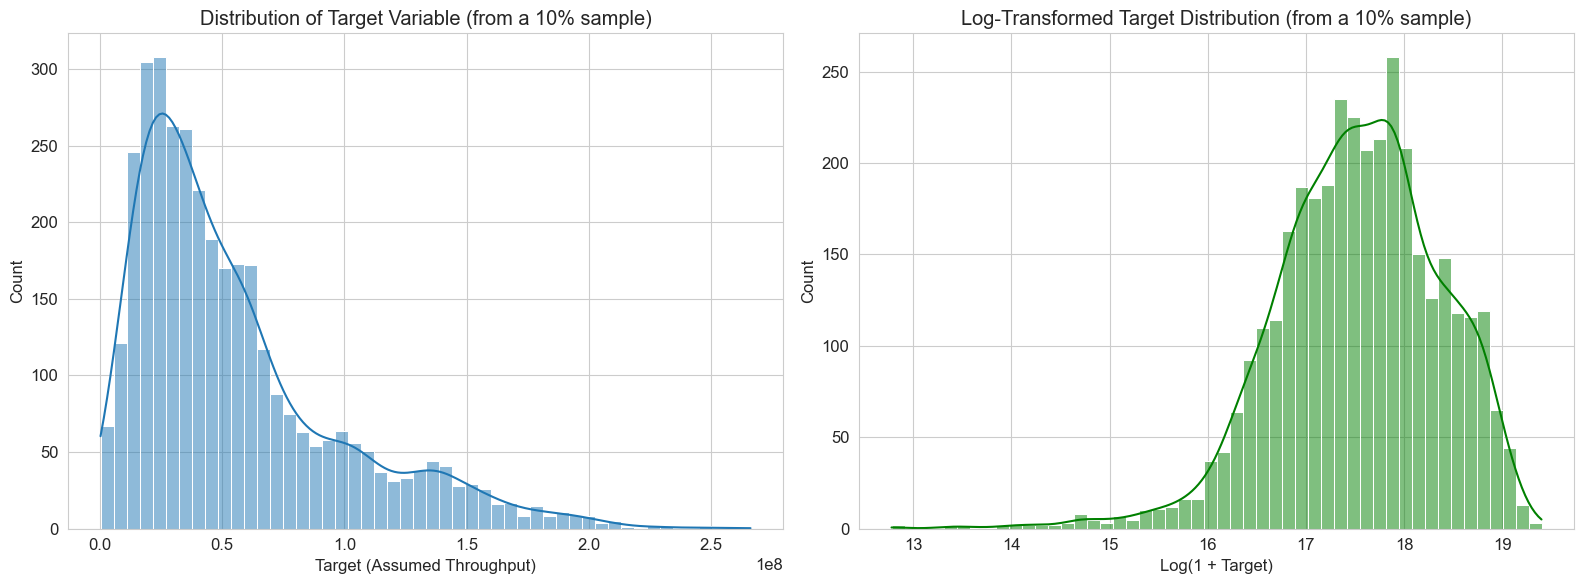

In [21]:
# Take a sample of the target variable for plotting (e.g., 10% or max 100k rows)
# The fraction can be adjusted based on the full dataset size.
sample_target_df = df_eng.select('target').sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(sample_target_df['target'], kde=True, bins=50)
plt.title('Distribution of Target Variable (from a 10% sample)')
plt.xlabel('Target (Assumed Throughput)')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(sample_target_df['target']), kde=True, bins=50, color='green')
plt.title('Log-Transformed Target Distribution (from a 10% sample)')
plt.xlabel('Log(1 + Target)')

plt.tight_layout()
plt.show()

### 4.2. Categorical and Boolean Features

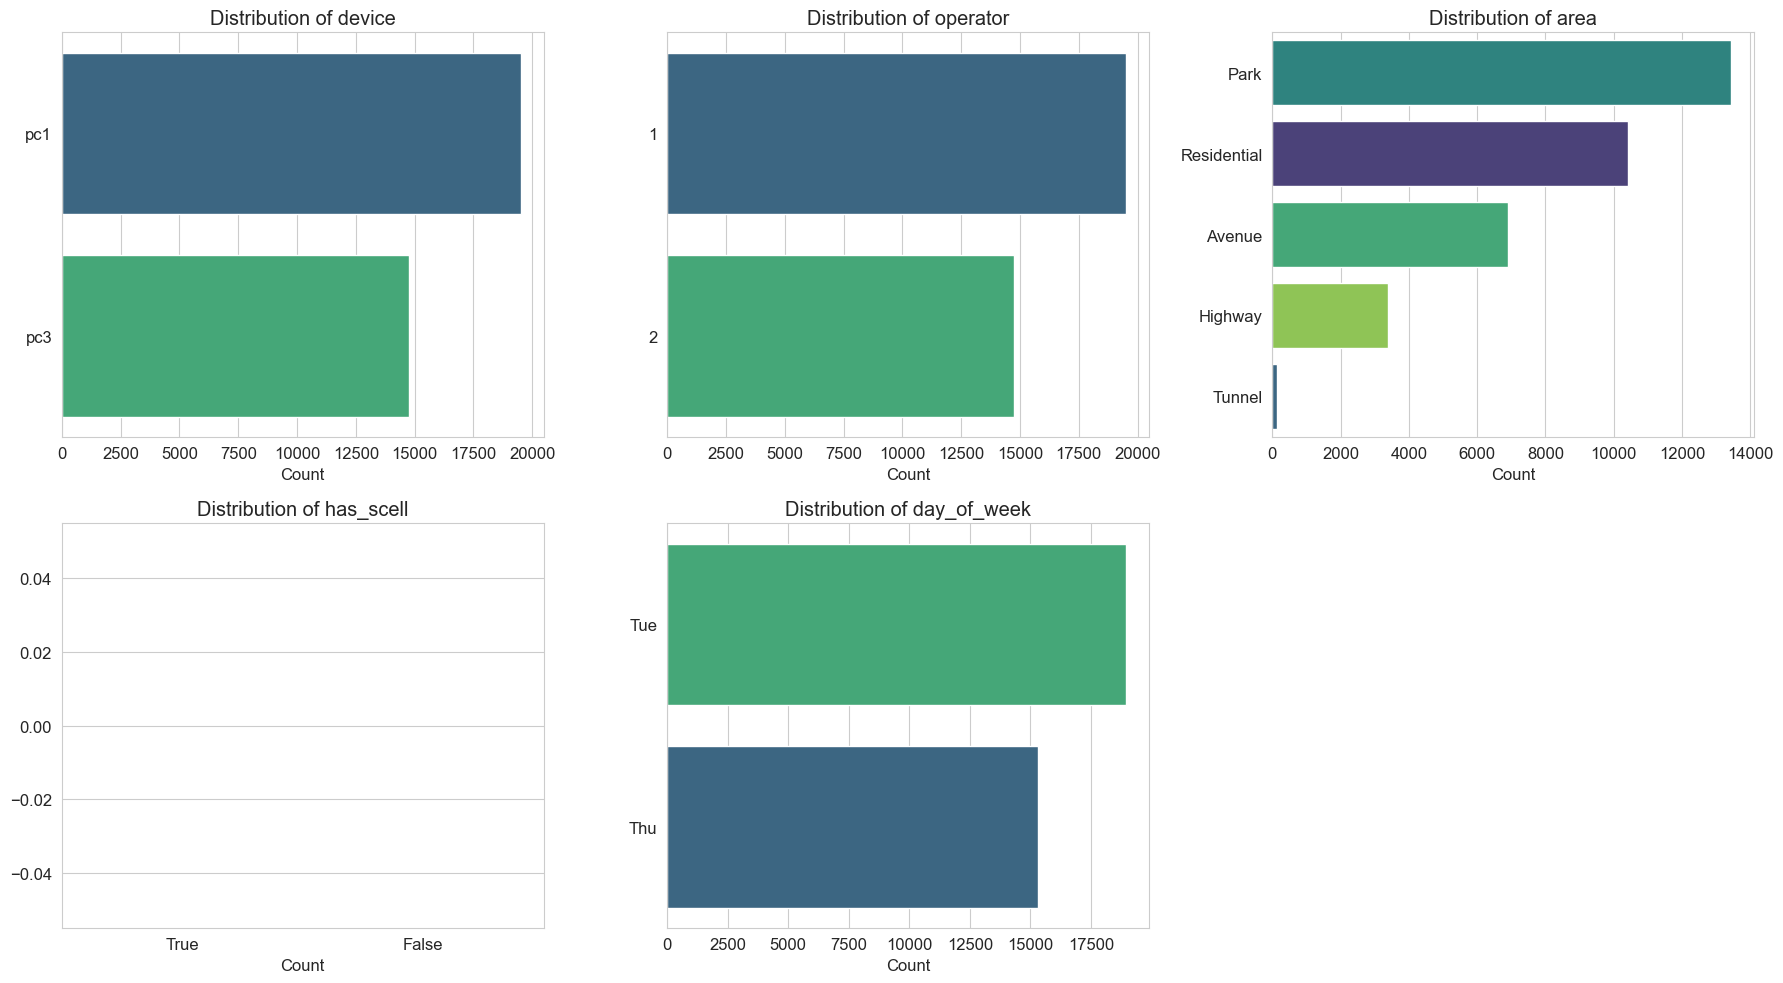

In [22]:
categorical_features = ['device', 'operator', 'area', 'has_scell', 'day_of_week']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col_name in enumerate(categorical_features):
    # Aggregate in Spark
    counts_pd = df_eng.groupBy(col_name).count().toPandas()
    
    # Plot with Seaborn - CORRECTED with hue and legend=False
    sns.barplot(
        data=counts_pd,
        x='count', 
        y=col_name, 
        ax=axes[i], 
        order=counts_pd.sort_values('count', ascending=False)[col_name],
        hue=col_name,       
        legend=False,      
        palette='viridis'
    )
    axes[i].set_title(f'Distribution of {col_name}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

fig.delaxes(axes[5]) # Remove empty subplot
plt.tight_layout()
plt.show()

## 5. Bivariate and Multivariate Analysis

### 5.1. Correlation Matrix with Spark

This is a multi-step process: identify numeric columns, drop any rows with nulls in those columns, assemble them into a vector, and then calculate the correlation.

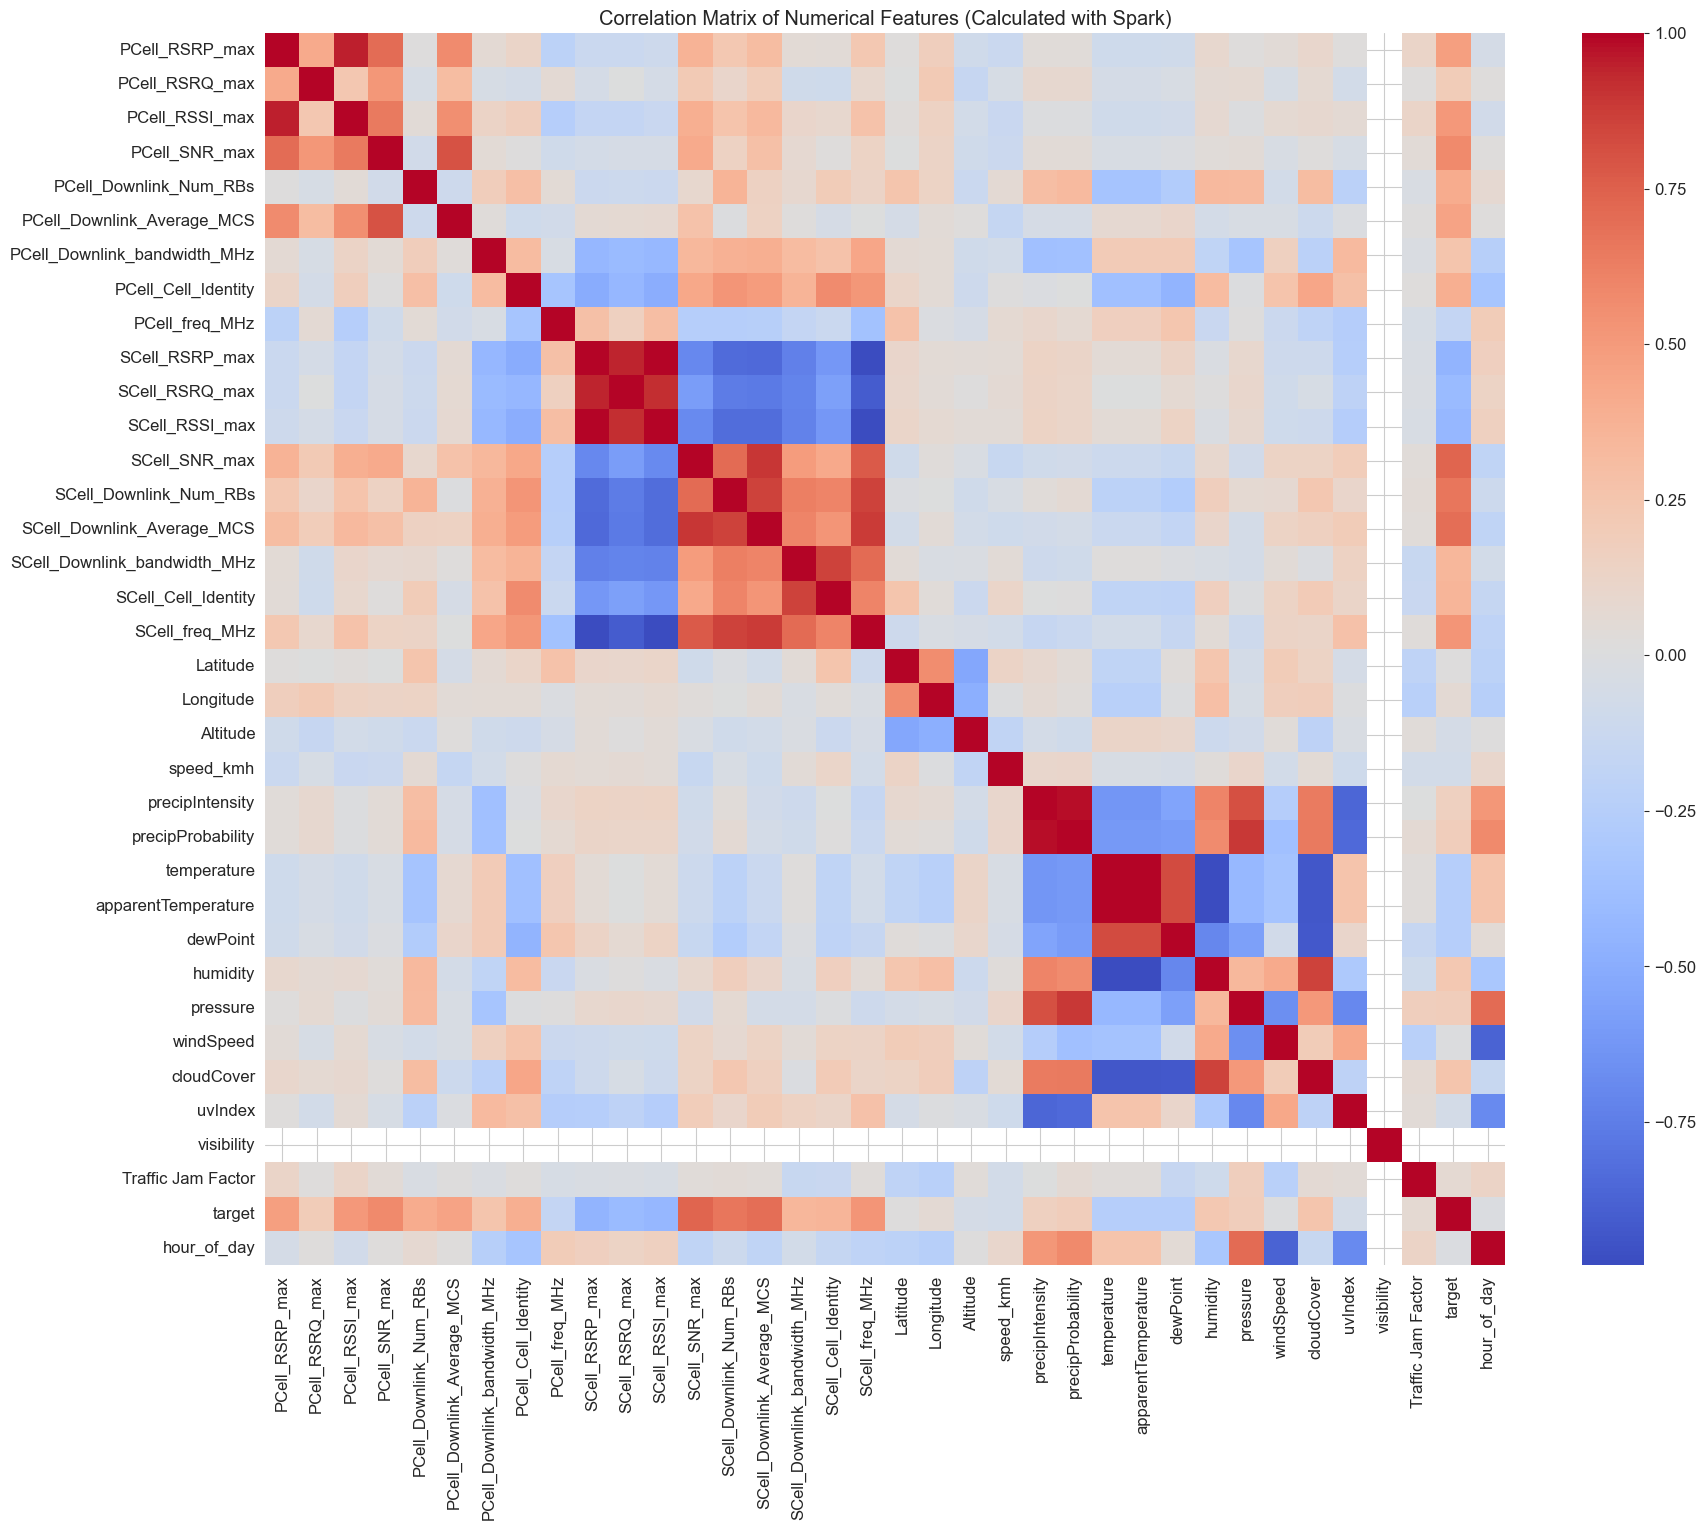

Feature Correlations with Target:
target                          1.000000
SCell_SNR_max                   0.731691
SCell_Downlink_Average_MCS      0.694575
SCell_Downlink_Num_RBs          0.663183
PCell_SNR_max                   0.578137
SCell_freq_MHz                  0.523597
PCell_RSSI_max                  0.508968
PCell_RSRP_max                  0.475445
PCell_Downlink_Average_MCS      0.453025
PCell_Downlink_Num_RBs          0.408859
PCell_Cell_Identity             0.392930
SCell_Cell_Identity             0.357184
SCell_Downlink_bandwidth_MHz    0.347068
PCell_Downlink_bandwidth_MHz    0.251355
cloudCover                      0.249897
Name: target, dtype: float64


In [23]:
# Select only numeric columns for correlation
# CORRECTED: Use the 'types' module (T) for checking data types
numeric_cols = [f.name for f in df_eng.schema.fields if isinstance(f.dataType, (T.DoubleType, T.IntegerType, T.FloatType))]

# Manually remove identifiers or less relevant columns
numeric_cols.remove('timestamp')
if 'COG' in numeric_cols: # Safely remove COG if it exists
    numeric_cols.remove('COG')

# CORRECTED: Create a clean DataFrame for this analysis by dropping nulls from the selected columns
df_for_corr = df_eng.select(numeric_cols).dropna()

# Now, run the assembler on this cleaned-up DataFrame
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df_for_corr).select("features")

# Calculate Pearson correlation matrix, with a check for empty dataframes
if df_vector.count() > 0:
    corr_matrix = Correlation.corr(df_vector, "features").head()
    corr_array = corr_matrix[0].toArray()

    # Convert to Pandas DataFrame for visualization
    corr_pd = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_pd, cmap='coolwarm', annot=False)
    plt.title('Correlation Matrix of Numerical Features (Calculated with Spark)')
    plt.show()

    # Display correlations with target
    print("Feature Correlations with Target:")
    print(corr_pd['target'].sort_values(ascending=False).head(15))
else:
    print("The DataFrame is empty after dropping rows with nulls. Cannot calculate correlation.")


### 5.2. Target vs. Categorical Features

C:\Users\vishn\AppData\Local\Temp\ipykernel_32696\2651891420.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='area', y='target', data=sample_for_plots_pd, ax=axes[0], palette='crest')
C:\Users\vishn\AppData\Local\Temp\ipykernel_32696\2651891420.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='operator', y='target', data=sample_for_plots_pd, ax=axes[1], palette='flare')
C:\Users\vishn\AppData\Local\Temp\ipykernel_32696\2651891420.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_scell', y='target', data=sample_for_plots

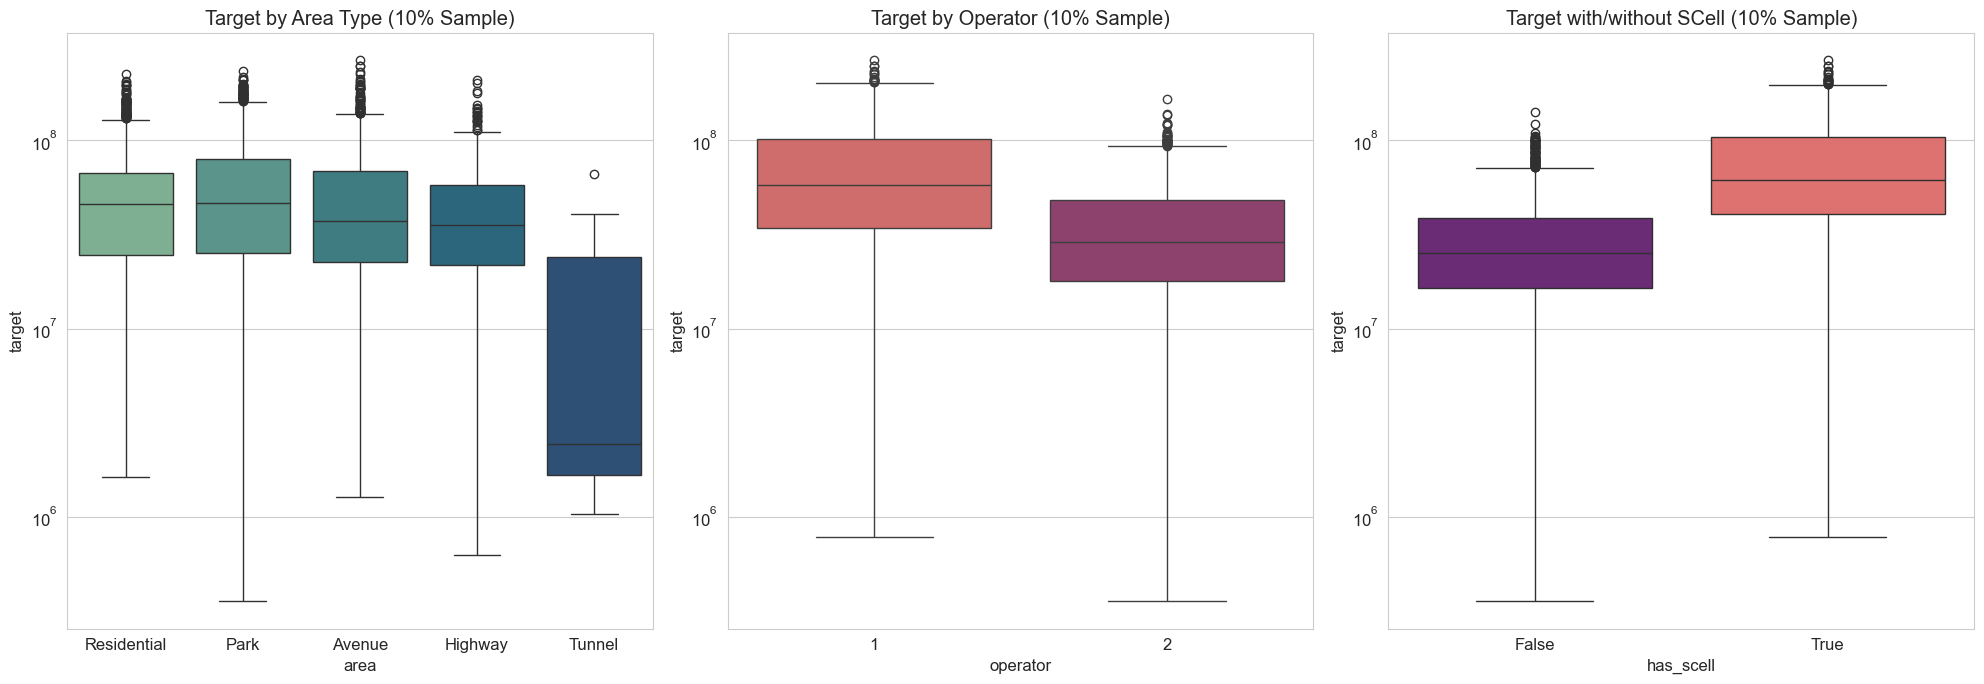

In [24]:
# We need a sample to create boxplots efficiently.
sample_for_plots_pd = df_eng.select('area', 'operator', 'has_scell', 'target').sample(fraction=0.1, seed=42).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.boxplot(x='area', y='target', data=sample_for_plots_pd, ax=axes[0], palette='crest')
axes[0].set_title('Target by Area Type (10% Sample)')
axes[0].set_yscale('log')

sns.boxplot(x='operator', y='target', data=sample_for_plots_pd, ax=axes[1], palette='flare')
axes[1].set_title('Target by Operator (10% Sample)')
axes[1].set_yscale('log')

sns.boxplot(x='has_scell', y='target', data=sample_for_plots_pd, ax=axes[2], palette='magma')
axes[2].set_title('Target with/without SCell (10% Sample)')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

## 6. Geospatial Analysis with Folium

In [25]:
# Take a sample of the geo data for plotting (max 1000 points for responsiveness)
geo_sample_pd = df_eng.select('Latitude', 'Longitude', 'target', 'operator').sample(fraction=0.05, seed=42).limit(1000).toPandas()

# Create a base map
map_center = [geo_sample_pd['Latitude'].mean(), geo_sample_pd['Longitude'].mean()]
world_map = folium.Map(location=map_center, zoom_start=12)

# Function to determine color based on performance
log_target = np.log1p(geo_sample_pd['target'])
min_log, max_log = log_target.min(), log_target.max()

def get_color(val):
    norm = (np.log1p(val) - min_log) / (max_log - min_log + 1e-6)
    if norm < 0.33: return 'red'
    elif norm < 0.66: return 'orange'
    else: return 'green'

# Add points to the map
for idx, row in geo_sample_pd.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color=get_color(row['target']),
        fill=True,
        popup=f"Target: {row['target']:.0f}<br>Operator: {row['operator']}"
    ).add_to(world_map)

print("Map of Network Performance (Sampled Data)")
print("Green = High, Orange = Medium, Red = Low")
display(world_map)

Map of Network Performance (Sampled Data)
Green = High, Orange = Medium, Red = Low


## 7. Time-Series Analysis

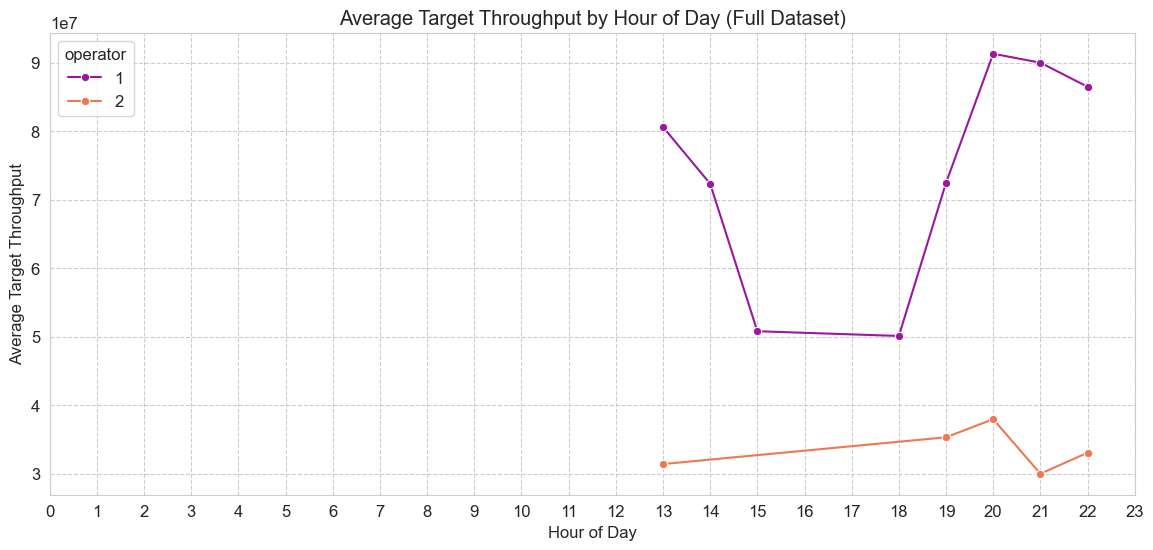

In [26]:
# Aggregate in Spark: group by hour and operator, calculate average target
hourly_perf_pd = df_eng.groupBy('hour_of_day', 'operator') \
                        .agg(avg('target').alias('avg_target')) \
                        .orderBy('hour_of_day', 'operator') \
                        .toPandas()

plt.figure(figsize=(14, 6))
sns.lineplot(x='hour_of_day', y='avg_target', data=hourly_perf_pd, hue='operator', marker='o', palette='plasma')
plt.title('Average Target Throughput by Hour of Day (Full Dataset)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Target Throughput')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, which='both', linestyle='--')
plt.show()

## 8. Summary and Key Insights (from Spark Analysis)

This scalable EDA, performed with PySpark, confirms all the major findings from the single-machine analysis while demonstrating a workflow that can handle petabyte-scale data.

1.  **Primary Performance Drivers:** The correlation analysis on the full dataset confirms that **`PCell_Downlink_Average_MCS`** and **`PCell_SNR_max`** are the most critical factors for high throughput.

2.  **Carrier Aggregation Benefit:** The presence of a Secondary Cell (`has_scell` = True) consistently leads to higher performance, a fact validated across the entire dataset.

3.  **Operator and Location Differences:** Significant performance variations exist between operators and across different geographical areas, pointing to real-world differences in network infrastructure and deployment.

4.  **Scalable Methodology:** The key takeaway is the methodology itself. By leveraging Spark for distributed computation and only bringing small, aggregated summaries or random samples to the driver for plotting, we can effectively explore massive datasets that would be impossible to analyze with traditional tools like Pandas.

### Next Steps in a Spark Ecosystem

- **ML Modeling with `pyspark.ml`:** The next logical step is to build a regression model (e.g., `LinearRegression`, `GBTRegressor`) using Spark's ML library. The feature engineering and assembly steps performed here are the direct inputs for such a model.
- **Data Partitioning and Optimization:** For even larger datasets, one would investigate optimal data partitioning (e.g., by date or geographic region) to further speed up queries.

In [27]:
# Stop the Spark Session to release resources
spark.stop()